In [120]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

N = 100
doors_ts = [24, 25, 26, 49, 50, 51, 74, 75, 76, 98, 99, 100]
# doors_ts = [25, 50, 75, 100]
# doors_xs = [[-1.5, -0.5], [0.5, 1.5], [-1.5, -0.5], [0.5, 1.5]]
# doors_xs = [[-0.5, 0.5] ] * len(doors_ts)
# doors_xs = [[1, 1.5] ] * len(doors_ts)
doors_xs = ([[-1.5, -0.5]] * 3 + [[0.5, 1.5]] * 3) * 2
assert len(doors_xs) == len(doors_ts)
door_penalty = 100000
# basis = [
#     lambda x: np.ones_like(x),  # 1
#     lambda x: x,  # x
#     lambda x: x * x,  # x²
#     # lambda x: x ** 3,  # x³
#     # lambda x: x ** 4,  # x³
#     # lambda x: x ** 5,  # x³
# ]
basis = [
    lambda x: np.ones_like(x) / 2,  # 1
    lambda x: x * 0.4330127018922193,  # x
    lambda x: 0.5590169943749475 - 0.4192627457812106 * x * x,  # x²
    # lambda x: x ** 3,  # x³
    # lambda x: x ** 4,  # x³
    # lambda x: x ** 5,  # x³
]

# 1/2
# sqrt(3)/4*x
# sqrt(5)/4 - (3 sqrt(5))/16 x^2


DOMAIN = [-2, 2]
DU = np.linspace(-100, 100, 201)  # controls belong to a compact set
DX = np.linspace(*DOMAIN, 201)


def uniform_mu_generaror(domain=DOMAIN):
    def mu(shape=None):
        return np.random.uniform(*domain, shape or 1)

    return mu


def calc_inverse_of_the_covariance_matrix(basis, mu, domain=DOMAIN):
    return np.eye(3)

    # samples = 10 ** 7
    # s = len(basis)
    # A = np.zeros((s, s))
    # domain_len = domain[1] - domain[0]
    # for i in range(0, s):
    #     for j in range(i, s):
    #         xxs = mu(samples)
    #         A[i, j] = np.sum(basis[i](xxs) * basis[j](xxs)) / samples * domain_len  # domain_len
    #         A[j, i] = A[i, j]
    # return A


    # A = np.array([
    #     [4, 0, 16/3],
    #     [0, 16/3, 0],
    #     [16/3, 0, 64/5],
    # ]) / 4

    # A = np.array([[1., 0.5, 1/3],
    #               [0.5, 1/3, 0.25],
    #               [1/3, 0.25, 0.2]])
    # return np.linalg.inv(A)


# test = calc_inverse_of_the_covariance_matrix(
#     basis=[lambda x: np.ones_like(x), lambda x: x, lambda x: x * x],
#     mu=uniform_mu_generaror([0, 1]),
#     domain=[0, 1]
# )
# from scipy.linalg import hilbert
# exact = hilbert(3)
# print(np.linalg.inv(test) - exact)
# # [[ 1.11022302e-15  1.52118847e-04  4.77328631e-05]
# #  [ 1.52118847e-04 -1.09971298e-04  1.23229863e-04]
# #  [ 4.77328631e-05  1.23229863e-04  9.60501358e-05]]
# # Покатит


def calc_next_x(x, u, xi, domain=DOMAIN):  
    return np.maximum(np.minimum(x + u / 100 + xi / 10, domain[1]), domain[0])
    # return np.maximum(np.minimum(x + (1 + x + u)/100 + xi / 10, domain[1]), domain[0])


def terminal_condition(x):
    # return x * 0
    dl, dr = doors_xs[-1]
    # return 10**11
    # return 10000 * ((x < dl) | (x > dr))
    return ((x < dl) | (x > dr)) * door_penalty * -1.0
    # return - x * x


def running_reward(s, x, u):
    # cost = -1 * u * u - x * x
    # cost = -1 * u * u - x * x * 10000
    # return cost

    # cost = -(u * u + x * x) / 100
    cost = -1 * u * u + 0 * x  # 0*x — это хак с формой массива
    for ti, (dl, dr) in zip(doors_ts, doors_xs):
        cost -= (s == ti) * ((x < dl) | (x > dr)) * door_penalty
    return cost


def cost_functional(n, N, Xs, Us):
    """"""
    res = terminal_condition(Xs[N])
    for s in range(n, N):
        res += running_reward(s, Xs[s], Us[s])
    return res
    # return np.sum(running_reward(s, Xs[n:N], Us[n:N])) + terminal_condition(Xs[N])


def calc_phi_n_k_hat(x, u, basis):
    ##
    # samples = 64
    # xi = np.random.normal(size=samples).reshape(-1, 1, 1)
    ## bas_func(calc_next_x(x, u, xi)).shape = (samples, |DU|, M)
    ## np.average(bas_func(calc_next_x(x, u, xi)), axis=0).shape = (|DU|, M)
    # phi_n_k_hat = np.array([np.average(bas_func(calc_next_x(x, u, xi)), axis=0) for bas_func in basis])

    phi_n_k_hat = np.array([bas_func(calc_next_x(x, u, 0)) for bas_func in basis])
    # phi_n_k_hat.shape = (|basis|, |DU|, |X| = M)
    return phi_n_k_hat


def regress_later_Monte_Carlo_algorithm_Value_iteration(M, inverse_of_the_covariance_matrix, mu, basis):
    # Generate i.i.d. training points with the distribution µ.
    X = mu((N + 1, M))
    # Initialise the value function
    V = np.zeros((N + 1, M), dtype=float)
    V[N, :] = terminal_condition(X[N, :])
    # V[i, j] — это значение V[i] на X[i, j]
    # initialise Random projection operators
    alpha = np.zeros((N + 1, len(basis)), dtype=float)
    DU_as_row = DU.reshape(-1, 1)
    for n in range(N - 1, -1, -1):
        print(n, '...')
        alpha[n + 1, :] = (
                inverse_of_the_covariance_matrix
                @
                np.array([np.average(V[n + 1, :] * bas_func(X[n + 1, :])) for bas_func in basis])
        )
        # f_n_X_n_all_u_all — массив формы (|DU|, M).
        # Для каждого u∈DU и каждого m=0..M-1 f_n_X_n_all_u_all[u, m] = f(n, X[n, m], u)
        f_n_X_n_all_u_all = running_reward(n, X[n, :], DU_as_row)
        # f_n_X_n_all_u_all.shape = (|DU|, M)
        phi_n_k_hat = calc_phi_n_k_hat(X[n, :], DU_as_row, basis)
        alpha_k_phi_n_k = phi_n_k_hat * alpha[n + 1, :].reshape(-1, 1, 1)
        # phi_n_k_hat.shape = (|basis|, |DU|, M)
        V[n, :] = np.max(f_n_X_n_all_u_all + np.sum(alpha_k_phi_n_k, axis=0), axis=0)
    return alpha, V


def regress_later_Monte_Carlo_algorithm_performance_iteration(M, inverse_of_the_covariance_matrix, mu, basis):
    # Generate i.i.d. training points with the distribution µ.
    X = mu((N + 1, M))
    # Initialise the value function
    J = np.zeros((N + 1, M), dtype=float)
    J[N, :] = terminal_condition(X[N, :])
    # V[i, j] — это значение V[i] на X[i, j]
    # initialise Random projection operators
    alpha = np.zeros((N + 1, len(basis)), dtype=float)
    DU_as_row = DU.reshape(-1, 1)
    for n in range(N - 1, -1, -1):
        print(n, '...')
        alpha[n + 1, :] = (
                inverse_of_the_covariance_matrix
                @
                np.array([np.average(J[n + 1, :] * bas_func(X[n + 1, :])) for bas_func in basis])
        )
        cur_Xs, cur_Us = calc_tracks(n, X[n, :], alpha, M)
        # for s in range(n, N):
        #     J[n, :] += running_reward(n, cur_Xs[s, :], cur_Us[s, :])
        J[n, :] = cost_functional(n, N, cur_Xs, cur_Us)
    return alpha, J


def calc_tracks(n, x, alpha, M):
    xs = np.zeros((N + 1, M))
    us = np.zeros((N + 1, M))
    xs[n, :] = x
    DU_as_row = DU.reshape(-1, 1)

    xis = np.random.normal(size=(N + 1, M))
    for j in range(n + 1, N):
        f_n_X_n_u_all = running_reward(j, xs[j - 1, :], DU_as_row)
        # f_n_X_n_all_u_all.shape = (|DU|, runs)
        phi_n_k_hat = calc_phi_n_k_hat(xs[j - 1, :], DU_as_row, basis)
        # phi_n_k_hat.shape = (K, |DU|, runs)
        alpha_k_phi_n_k = phi_n_k_hat * alpha[j + 1, :].reshape(-1, 1, 1)
        to_argmax = (f_n_X_n_u_all + np.sum(alpha_k_phi_n_k, axis=0))
        # to_argmax.shape = (|DU|, runs)
        ui = to_argmax.argmax(axis=0)  # В pdf-ке здесь max.
        # ui.shape = (runs)
        best_u = DU[ui]
        us[j, :] = best_u
        xs[j, :] = calc_next_x(xs[j - 1, :], best_u, xis[j, :])
    return xs, us


def Monte_Carlo_simulation(x, alpha, runs):
    xs, us = calc_tracks(0, x, alpha, M)
    return xs

def Monte_Carlo_simulation_u(x, alpha, runs):
    xs, us = calc_tracks(0, x, alpha, M)
    return xs, us

def value_function_heat_map(alpha):
    # Для каждой точки вычислим управление
    us = np.zeros((N + 1, len(DX)))
    V = np.zeros((N + 1, len(DX)))
    DU_as_row = DU.reshape(-1, 1)
    for n in range(1, N + 1):
        print('n=', n - 1, '...')
        for i, x in enumerate(DX):
            f_n_X_n_u_all = running_reward(n - 1, x, DU_as_row)
            phi_n_k_hat = calc_phi_n_k_hat(x, DU_as_row, basis)
            alpha_k_phi_n_k = phi_n_k_hat * alpha[n, :].reshape(-1, 1, 1)
            to_argmax = (f_n_X_n_u_all + np.sum(alpha_k_phi_n_k, axis=0))
            ui = to_argmax.argmax(axis=0)  # В pdf-ке здесь max.
            us[n, i] = DU[ui]
            V[n - 1, i] = to_argmax[ui]  # В pdf-ке здесь max.
    return us, V


# def stupid_value_function():
#     V = np.zeros((N+1, len(DX)))
#     V[N, :] = terminal_condition(DX)
#     DU_as_row = DU.reshape(-1, 1)
#     for n in range(N - 1, -1, -1):
#         for i, x in enumerate(DX):
#             f_n_X_n_u_all = running_reward(n, x, DU_as_row)
#             calc_next_x(x, DU_as_row, 0)


mu = uniform_mu_generaror(DOMAIN)
inverse_of_the_covariance_matrix = calc_inverse_of_the_covariance_matrix(basis, mu, domain=DOMAIN)
print(inverse_of_the_covariance_matrix)
M = 4096
s = input("Input 'v' for Value iteration or 'p' for Performance iteration: ")
f = regress_later_Monte_Carlo_algorithm_Value_iteration if s == 'v' else regress_later_Monte_Carlo_algorithm_performance_iteration
alphas, V = f(M, inverse_of_the_covariance_matrix, mu, basis)
from timeit import timeit
print("!!!!!!!!!!!!!!!!!!!", 
      timeit("regress_later_Monte_Carlo_algorithm_performance_iteration(M, inverse_of_the_covariance_matrix, mu, basis)", 
             number=1,
             globals=globals()))

alphas, V = regress_later_Monte_Carlo_algorithm_Value_iteration(M, inverse_of_the_covariance_matrix, mu, basis)

runs = 50
xs = Monte_Carlo_simulation(x=0.0, alpha=alphas, runs=runs)

fix, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15, 15))

for i in range(runs):
    ax3.plot(xs[:, i], label=f"Run {i}")
ax3.set_ylim(*DOMAIN)
plt.vlines(x=doors_ts, ymin=[d[0] for d in doors_xs], ymax=[d[1] for d in doors_xs], colors='green', lw=5, label='door')




us, V = value_function_heat_map(alpha=alphas)
# us = V
df1 = pd.DataFrame(data=V.T, index=np.round(DX * 100), columns=list(range(N + 1)))
sns.heatmap(df1, linewidth=0, ax=ax1)

df2 = pd.DataFrame(data=us.T, index=np.round(DX * 100), columns=list(range(N + 1)))
sns.heatmap(df2, linewidth=0, ax=ax2)

plt.show()

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Input 'v' for Value iteration or 'p' for Performance iteration: v
99 ...
98 ...
97 ...
96 ...
95 ...
94 ...
93 ...
92 ...
91 ...
90 ...
89 ...
88 ...
87 ...
86 ...
85 ...
84 ...
83 ...
82 ...
81 ...
80 ...
79 ...
78 ...
77 ...
76 ...
75 ...
74 ...
73 ...
72 ...
71 ...
70 ...
69 ...
68 ...
67 ...
66 ...
65 ...
64 ...
63 ...
62 ...
61 ...
60 ...
59 ...
58 ...
57 ...
56 ...
55 ...
54 ...
53 ...
52 ...
51 ...
50 ...
49 ...
48 ...
47 ...
46 ...
45 ...
44 ...
43 ...
42 ...
41 ...
40 ...
39 ...
38 ...
37 ...
36 ...
35 ...
34 ...
33 ...
32 ...
31 ...
30 ...
29 ...
28 ...
27 ...
26 ...
25 ...
24 ...
23 ...
22 ...
21 ...
20 ...
19 ...
18 ...
17 ...
16 ...
15 ...
14 ...
13 ...
12 ...
11 ...
10 ...
9 ...
8 ...
7 ...
6 ...
5 ...
4 ...
3 ...
2 ...
1 ...
0 ...
99 ...
98 ...
97 ...
96 ...
95 ...
94 ...
93 ...
92 ...
91 ...
90 ...
89 ...
88 ...
87 ...
86 ...
85 ...
84 ...
83 ...
82 ...
81 ...
80 ...
79 ...
78 ...
77 ...
76 ...
75 ...
74 ...
73 ...
72 ...
71 ...
70 .

KeyboardInterrupt: 

In [ ]:
mu = uniform_mu_generaror(DOMAIN)
inverse_of_the_covariance_matrix = calc_inverse_of_the_covariance_matrix(basis, mu, domain=DOMAIN)
print(inverse_of_the_covariance_matrix)
M = 4096
# alphas, V = regress_later_Monte_Carlo_algorithm_Value_iteration(M, inverse_of_the_covariance_matrix, mu, basis)
from timeit import timeit
print("ELAPSED", 
      timeit("regress_later_Monte_Carlo_algorithm_performance_iteration(M, inverse_of_the_covariance_matrix, mu, basis)", 
             number=1,
             globals=globals()))

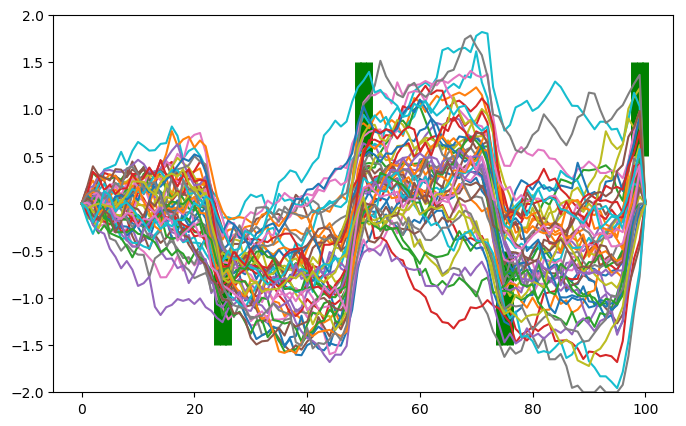

In [117]:
def Monte_Carlo_simulation_u(x, alpha, runs):
    xs, us = calc_tracks(0, x, alpha, M)
    return xs, us

xs, us = Monte_Carlo_simulation_u(x=0.0, alpha=alphas, runs=10000)
fig, ax = plt.subplots()
for i in range(runs):
    plt.plot(xs[:, i], label=f"Run {i}")
ax.set_ylim(*DOMAIN)
plt.vlines(x=doors_ts, ymin=[d[0] for d in doors_xs], ymax=[d[1] for d in doors_xs], colors='green', lw=5, label='door')
plt.show()

[-100000. -100000. -100000. ... -100000. -100000. -100000.]


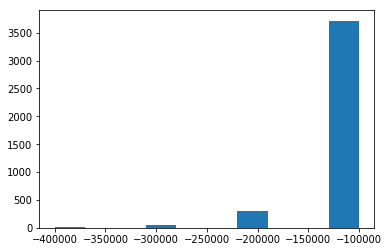

In [98]:
performance = cost_functional(0, N, xs, us)
plt.hist(performance)
print(performance)

In [102]:
Value = cost_functional(0, N, xs, us)

(-111450.1953125, -751531.2824707031)

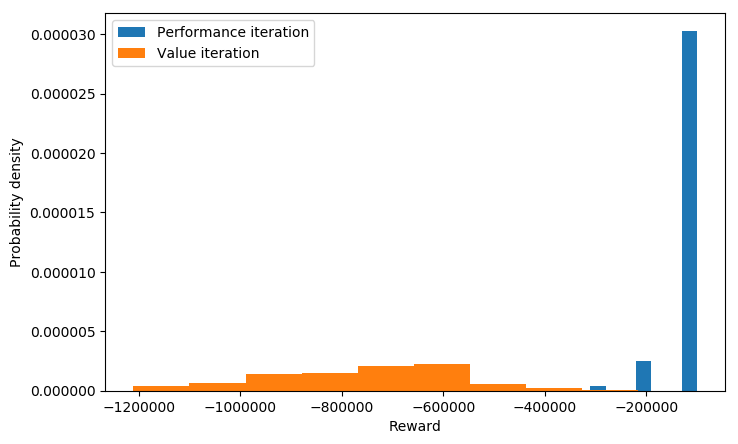

In [116]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.hist(performance, density=True, label="Performance iteration")
plt.hist(Value, density=True, label="Value iteration")
plt.xlabel("Reward")
plt.ylabel("Probability density")
plt.legend()
np.mean(performance), np.mean(Value)